
# Summary:

in this notebook, we first make the two Chicago and San Diego datasets similar in terms of features and then we run the baseline ML methods, Transfer learning and domain adaptation models on them. We aim to transfer from one city to another.

- Regression
- Timeline Split
- Results reported after statistical significance test
- Nan values: Noisy Mean
- Augmentation: No Aug

### Libraries

In [1]:
# pip install adapt stats

In [2]:
import numpy as np
import pandas as pd
import numpy
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from tqdm import tqdm
import stats
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import torch

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor as xgbc
from matplotlib import pyplot

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
import math

In [5]:
pd.options.display.max_rows = None

# Dataset

making two datasets similar

In [69]:
chi_data = pd.read_csv('./Data-CHI.csv') #Chicago Dataset

chi_data = chi_data.drop(columns={"Unnamed: 0.1", "Unnamed: 0", 'date', 'beach_area', "dayofyear", 'tide_gtm', 'dtide_1', 'dtide_2', 'PrecipSum6',
       'Precip24', 'solar_noon', 'APD', 'DPD', 'turbidity', 'atemp', 'comment', 'dtemp', 'WDIR', 'WSPD'})
chi_data['date'] = pd.to_datetime(chi_data[['year', 'month', 'day']])
chi_data['doy'] = chi_data['date'].dt.dayofyear
chi_data.loc[chi_data['logENT'] <= 0, 'logENT'] = 0
chi_data = chi_data.drop(columns={'date', 'month', 'day'})
chi_data['tide_gtm'] = np.where(chi_data['tide'] > chi_data.tide.mean(), 1, 0)
chi_data['ENT'] = chi_data['ENT'].apply(lambda x: 0.01 if x < 0.01 else x)
chi_data['logENT'] = np.log10(chi_data['ENT'])
chi_data = chi_data.drop(columns={"ENT"})
desc = chi_data.describe()
desc.loc['missing'] = [round(i, 3) for i in (10014-np.array(desc)[0])/10014*100]
desc

,year,logENT,tide,lograin3T,wet3,lograin7T,wet7,WVHT,Wtemp_B,rad,awind,owind,doy,tide_gtm
count,10014.000000,10014.000000,9434.000000,8918.000000,8918.000000,7867.000000,7867.00000,5346.000000,7105.000000,6234.000000,7561.000000,7561.000000,10014.000000,10014.000000
mean,2019.186339,2.058280,177.061424,-1.708177,0.502848,-0.553355,0.83310,0.260896,20.843561,351.164261,-0.128540,-0.724754,195.557619,0.356101
std,1.990949,0.695017,0.190851,1.674389,0.498058,1.143453,0.37091,0.219719,2.882013,252.721353,3.020049,3.151064,29.703664,0.478870
min,2016.000000,-2.000000,176.646840,-4.000000,0.000000,-4.000000,0.00000,0.010000,12.400000,0.000000,-21.570398,-19.967320,144.000000,0.000000
25%,2017.000000,1.618048,176.921160,-4.000000,0.000000,-0.698970,1.00000,0.110000,19.100000,66.000000,-1.574542,-2.338488,169.000000,0.000000
50%,2019.000000,2.084931,177.024792,-0.978811,1.000000,-0.130768,1.00000,0.190000,21.700000,405.500000,-0.055805,-0.817459,195.000000,0.000000
75%,2021.000000,2.521437,177.134520,-0.267606,1.000000,0.076457,1.00000,0.310000,22.900000,575.000000,1.340563,0.935142,221.000000,1.000000
max,2022.000000,5.033514,177.600864,0.479287,1.000000,0.641474,1.00000,1.390000,25.400000,757.000000,16.028410,20.958388,249.000000,1.000000
missing,0.000000,0.000000,5.792000,10.945000,10.945000,21.440000,21.44000,46.615000,29.049000,37.747000,24.496000,24.496000,0.000000,0.000000


In [78]:
san_data = pd.read_csv('./Data-SD.csv') #SanDiego Dataset
san_data['ActivityStartDate'] = pd.to_datetime(san_data['ActivityStartDate'])
san_data['year'] = san_data['ActivityStartDate'].dt.year
san_data = san_data.drop(columns={ 'ProjectIdentifier', 'tide_mean',\
                                  'LatitudeMeasure', 'LongitudeMeasure', 'WindDir', 'SLP',\
                                  'ActivityStartDate', 'hour', 'WindSpd', 'beach_angle'})
san_data = san_data.rename(columns={'MonitoringLocationIdentifier': 'beach'})
san_data = san_data.rename(columns={"ResultMeasureValue": "ENT", "WTMP": "Wtemp_B", "Water Level": "tide",\
                                   'DNI_1': 'rad', '3T': 'lograin3T', '7T': 'lograin7T'})
san_data['ENT'] = san_data['ENT'].apply(lambda x: 0.01 if x < 0.01 else x)
san_data['logENT'] = np.log10(san_data['ENT'])
# san_data = san_data.drop(columns={"ENT"})
desc = san_data.describe()
desc.loc['missing'] = [round(i, 3) for i in (8730-np.array(desc)[0])/10014*100]
desc

,ENT,doy,WVHT,Wtemp_B,tide,rad,AirTemp,visibility,wet3,wet7,lograin3T,lograin7T,tide_gtm,awind,owind,year,logENT
count,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000,8730.000000
mean,546.841410,187.120733,1.034499,18.864313,3.594962,2942.115349,18.770756,14819.279152,0.184994,0.366781,1.209416,3.687514,0.604582,0.007553,0.764905,2018.130699,1.389429
std,2119.159553,104.049436,0.474261,2.917555,1.712345,3328.580723,4.070062,2919.308338,0.388315,0.481954,4.831651,9.942902,0.488968,1.975906,1.717646,2.274089,0.912791
min,0.010000,1.000000,0.210000,13.300000,-1.044000,0.000000,3.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.400000,-7.700000,2014.000000,-2.000000
25%,10.000000,103.000000,0.720000,16.500000,2.397000,308.000000,16.100000,16000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.230000,0.000000,2016.000000,1.000000
50%,10.000000,189.000000,0.930000,18.500000,3.677000,1622.000000,18.900000,16093.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.450000,2019.000000,1.000000
75%,60.000000,275.000000,1.230000,20.800000,4.753000,4563.250000,21.700000,16093.000000,0.000000,1.000000,0.000000,1.300000,1.000000,1.470000,1.890000,2020.000000,1.778151
max,24000.000000,365.000000,4.380000,26.600000,7.830000,13938.000000,35.600000,16093.000000,1.000000,1.000000,61.400000,79.600000,1.000000,7.380000,8.370000,2021.000000,4.380211
missing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [71]:
common_features = [i for i in san_data.columns if i in chi_data.columns]
print('common_features:', common_features)

cf = ['doy', 'WVHT', 'Wtemp_B', 'tide', 'rad', 'wet3', 'wet7', 'lograin3T', 'lograin7T', 'tide_gtm', 'awind', 'owind', 'year', 'logENT']

common_features: ['doy', 'beach', 'WVHT', 'Wtemp_B', 'tide', 'rad', 'wet3', 'wet7', 'lograin3T', 'lograin7T', 'tide_gtm', 'awind', 'owind', 'year', 'logENT']


In [72]:
san_data = san_data.loc[:,common_features]
chi_data = chi_data.loc[:,common_features]

df_concat = pd.concat([san_data, chi_data])
# df_concat = chi_data
beaaaches = df_concat.beach.unique()
SB = ['Calumet','Margare','57th St','Oakwood','Rainbow','South S','63rd St']

NB = ['Howard','Osterma','Foster','Montros','Marion','Leone','Hartiga','Rogers']
    
CB = ['Oak Str','12th St','North A','Ohio St']

sbeach_map = {beaaaches[i]: 'San Diego Beach ' + str(i) for i in range(14)}
cbeach_map = {df_concat.beach.unique()[i]: 'Chicago Beach ' + str(i-14) for i in range(14, 14+19)}
b = []
# print(sbeach_map)
for i in df_concat.beach:
    if i in sbeach_map.keys():
        b.append('San Diego')
    if i in NB:
        b.append("Chicago")
    elif i in SB:
        b.append("Chicago")
    elif i in CB:
        b.append("Chicago")
print(len(b), len(df_concat))
df_concat.beach = b
df_concat.beach.unique()

18744 18744


array(['San Diego', 'Chicago'], dtype=object)

In [73]:
beaches = {o: [] for o in df_concat.beach.unique()}
  
results = pd.DataFrame(beaches)

display(results)

,San Diego,Chicago


In [74]:
def KL_div(P, Q):
    # First convert to np array
    P = np.array(P)
    Q = np.array(Q)
    
    # Then compute their means
    mu_P = np.nanmean(P, axis=0)
    mu_Q = np.nanmean(Q, axis=0)    
    
    # Compute their covariance
    cov_P = np.ma.cov(np.ma.masked_invalid(P), rowvar=False)
    cov_Q = np.ma.cov(np.ma.masked_invalid(Q), rowvar=False)
    cov_Q_inv = np.linalg.inv(cov_Q)
    
    # Compute KL divergence
    KL_div = np.log(np.linalg.det(cov_Q)/np.linalg.det(cov_P)) - mu_P.shape[0] + np.trace(cov_Q_inv@cov_P) + \
                (mu_P - mu_Q).T@cov_Q_inv@(mu_P - mu_Q)
    
    KL_div = 0.5 * KL_div
    # KL_div = np.log(1+KL_div)
    return KL_div

In [75]:
divergences = []
a = df_concat.beach.unique()
for i in df_concat.beach.unique():
    diverge_perbeach = []
    for j in df_concat.beach.unique():
        features_calumet = df_concat[df_concat['beach'] == i]
        features_margare = df_concat[df_concat['beach'] == j]
        # diverge_perbeach.append(JS_divergence(np.array(features_calumet.loc[:, cf]), np.array(features_margare.loc[:, cf])))
        diverge_perbeach.append((KL_div(
            features_calumet.loc[:, cf], 
            features_margare.loc[:, cf]
        ) + KL_div(
            features_margare.loc[:, cf],
            features_calumet.loc[:, cf]
        ))/2)
    
    results.loc[i] = diverge_perbeach

In [76]:
results

,San Diego,Chicago
San Diego,-8.881784e-16,7.821289e+05
Chicago,7.821289e+05,-1.776357e-15


nan


/Users/ali/miniforge_x86_64/envs/env_python/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ali/miniforge_x86_64/envs/env_python/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


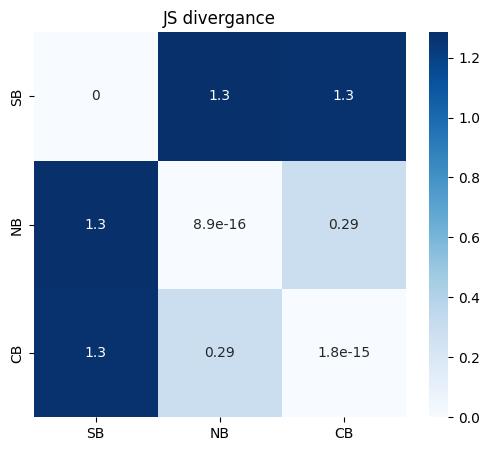

In [67]:
import seaborn as sns
print(np.mean(divergences))
plt.figure(figsize=(6,5))
plt.title('JS divergance')
sns.heatmap(results, annot=True, cmap=plt.cm.Blues)
# plt.show()
plt.savefig('./jsdivergence.png')

In [15]:
beaches = {o: [] for o in df_concat.beach.unique()}
  
results = pd.DataFrame(beaches)

display(results)

,CABEACH_WQX-IB-060,CABEACH_WQX-MB-205,CABEACH_WQX-MB-060,CABEACH_WQX-IB-020,CABEACH_WQX-IB-010,CABEACH_WQX-IB-050,CABEACH_WQX-IB-030,CABEACH_WQX-EH-010,CABEACH_WQX-FM-010,CABEACH_WQX-MB-053,...,Howard,Osterma,Foster,Oak Str,Oakwood,Marion,Leone,Hartiga,57th St,Rogers


In [23]:
from statistics import NormalDist
def NormalDistSimilarity(a, b):
    mean_a, std_a = np.array(a)
    mean_b, std_b = np.array(b)
    overlaps = np.nanmean([NormalDist(mu=i, sigma=j).overlap(NormalDist(mu=k, sigma=l)) for i, j, k, l in zip(mean_a, std_a, mean_b, std_b)])
    return 100*(1-overlaps)

In [24]:
alll = pd.DataFrame()

for i in df_concat.beach.unique():
    differences = []
    for j in df_concat.beach.unique():
        features_one = df_concat[df_concat['beach'] == i]
        features_two = df_concat[df_concat['beach'] == j]
        stats_one = features_one.describe()
        stats_two = features_two.describe()
        stats_one = stats_one.drop(labels=['count', '25%', '75%', '50%', 'min', 'max'], axis=0)
        stats_two = stats_two.drop(labels=['count', '25%', '75%', '50%', 'min', 'max'], axis=0)
        differences.append(NormalDistSimilarity(
        stats_one.loc[:, cf], 
        stats_two.loc[:, cf] 
        ))
    results.loc[i] = differences

/Users/ali/miniforge_x86_64/envs/env_python/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ali/miniforge_x86_64/envs/env_python/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan


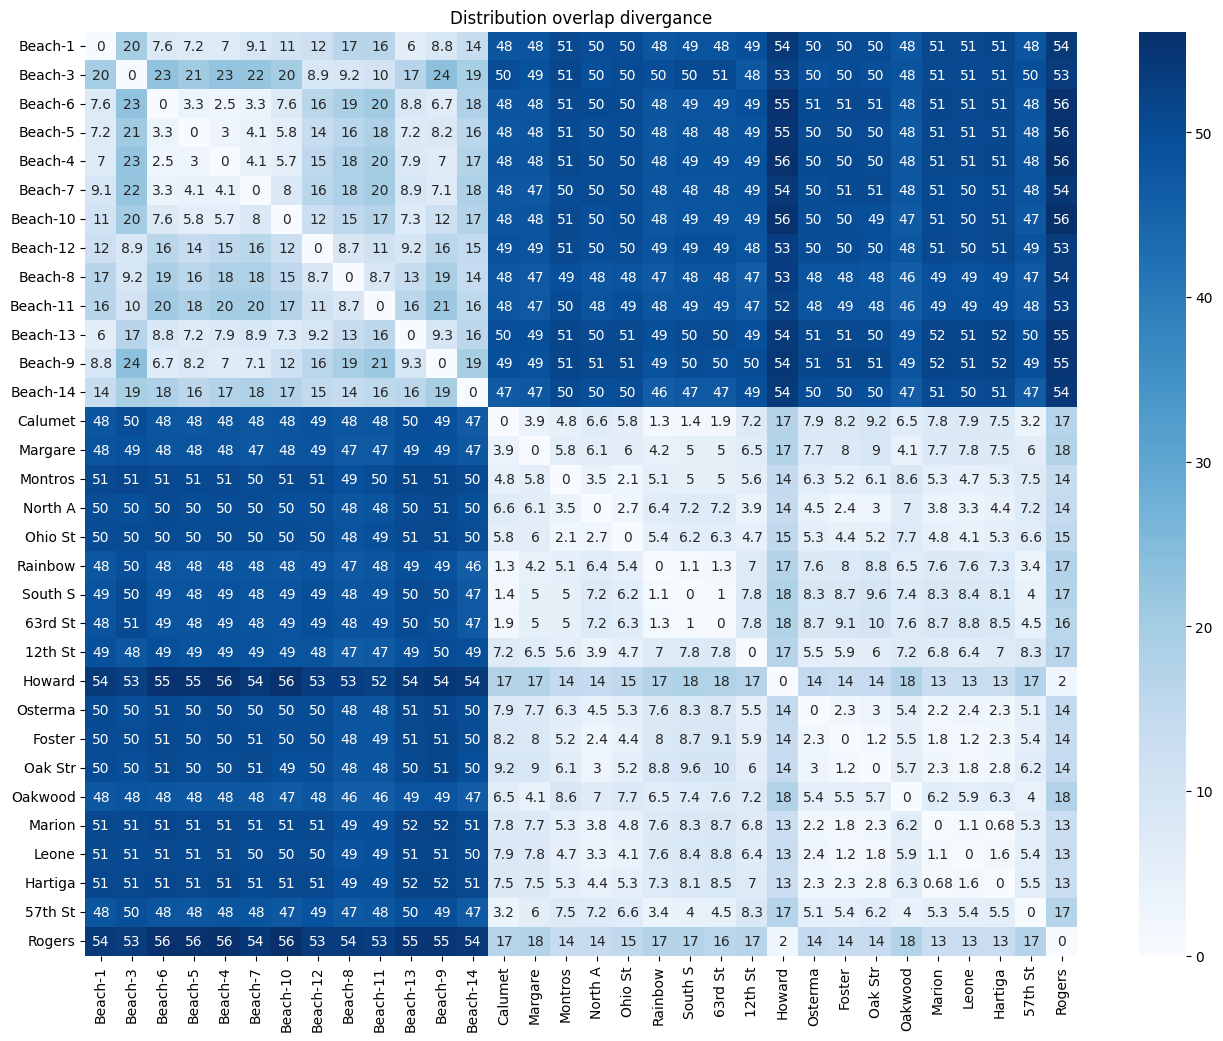

In [25]:
import seaborn as sns
print(np.mean(divergences))
plt.figure(figsize=(16,12))
plt.title('Distribution overlap divergance')
sns.heatmap(results, annot=True, cmap=plt.cm.Blues)
plt.savefig('./dist_overlap.png')